
# Energy Demand Forecasting with Granite Timeseries - Few-shot Fine-tuning and Evaluation

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multi-variate forecasts.

In this recipe, we move beyond zero-shot prediction to few-shot fine-tuning and prediction. We use a real-world dataset containing energy demand data from Spain.

## Setting Up

### Install the TSFM Library 

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here we retrieve and install a tested version of the library.

In [ ]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.17" -U

### Import Packages

From `tsfm_public`, we use the TinyTimeMixer model, forecasting pipeline, and plotting function.


In [2]:
import math
import os

import numpy as np
import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.time_series_preprocessor import prepare_data_splits
from tsfm_public.toolkit.visualization import plot_predictions

### Specify configuration variables

We provide the names of the timestamp column and the target column to be predicted. The context length (in time steps) is set to match the pretrained model.

In [3]:
timestamp_column = "time"
target_columns = ["total load actual", "generation solar"]

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"
context_length = 512  # the max context length for the 512-96 model
prediction_length = 96  # the max forecast length for the 512-96 model

# Return this percent of the original dataset when getting train/test splits.
fewshot_fraction = 0.05

# Output directory for writing evaluation results.
OUT_DIR = "/tmp/ttm_results"

## Preparing the Data

### Download the data

We'll work with a dataset of hourly electrical demand, generation by type, and weather in Spain. This dataset was originally available [from Kaggle here.](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather) To simplify access to the data, we will make use of versions available as Hugging Face datasets ([energy consumption](https://huggingface.co/datasets/vitaliy-sharandin/energy-consumption-hourly-spain) and [weather](https://huggingface.co/datasets/vitaliy-sharandin/energy-consumption-weather-hourly-spain)).



In [4]:
DATA_FILE_PATH = "hf://datasets/vitaliy-sharandin/energy-consumption-hourly-spain/energy_dataset.csv"
DATA_FILE_EXOG_PATH = "hf://datasets/vitaliy-sharandin/energy-consumption-weather-hourly-spain/weather_features.csv"

### Read in the data

We parse the CSV into a pandas dataframe, filling in any null values, and create a single window containing `context_length` time points. We ensure the timestamp column is a UTC datetime.

In [5]:
# Read in the data from the downloaded file.
input_df = pd.read_csv(DATA_FILE_PATH, parse_dates=[timestamp_column])

# Fill NA/NaN values by propagating the last valid value.
input_df = input_df.ffill()

# Show the last few rows of the dataset.
input_df.tail()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89
35063,2018-12-31 23:00:00+01:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3651.0,26.0,NaN,3117.0,24424.0,24455.0,64.27,69.88


We also read in the exogenous data. We use one day rolling average weather value as exogenous. Since the exact future weather values are unknown at the time of forecast, it is assumed, that a daily mean forecast is available for each location. We also need to aggregate the weather forecasts which are at a city level, whereas the energy demands are at a country level. We derive the representative weather forecast as a median weather forecast across different cities.

In [6]:
exog_timestamp_column = "dt_iso"
exog_data = pd.read_csv(
    DATA_FILE_EXOG_PATH,
    parse_dates=[exog_timestamp_column],
)

keep_cols = [
    c for c in exog_data.columns if c not in ["weather_id", "weather_main", "weather_description", "weather_icon"]
]
exog_data = exog_data[keep_cols]
value_cols = [c for c in keep_cols if c not in ["dt_iso", "city_name"]]

city_data = []
for city in exog_data.city_name.unique():
    df = (
        exog_data[exog_data.city_name == city].set_index("dt_iso")[value_cols].rolling(window=24, min_periods=1).mean()
    )
    df["city_name"] = city
    df = df.reset_index()
    city_data.append(df)

exog_df = pd.concat(city_data, axis=0).sort_values(by="dt_iso")
exog_df = exog_df.groupby("dt_iso")[value_cols].median()

Finally, we join the target data with the exogenous data

In [7]:
input_df = input_df.merge(exog_df, left_on=timestamp_column, right_on=exog_timestamp_column)

### Plot a segment of the target series

Here we inspect a preview of the target time series.

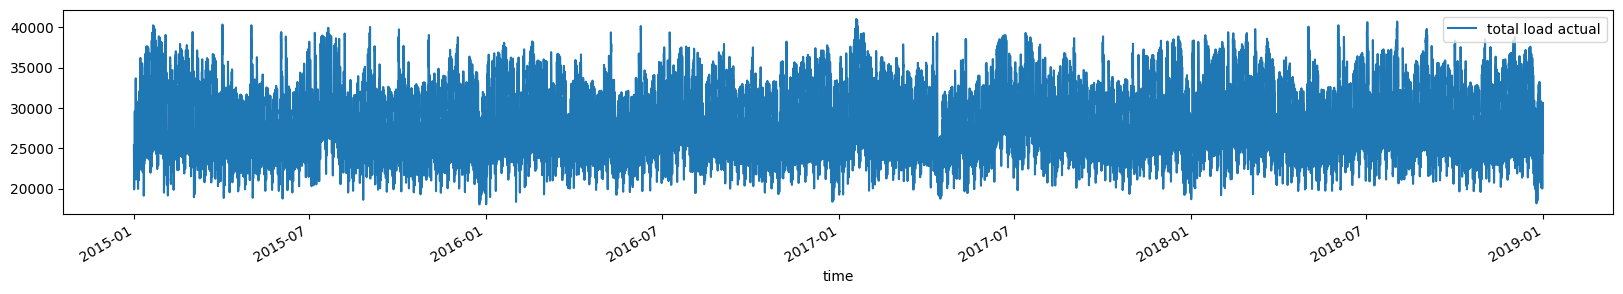

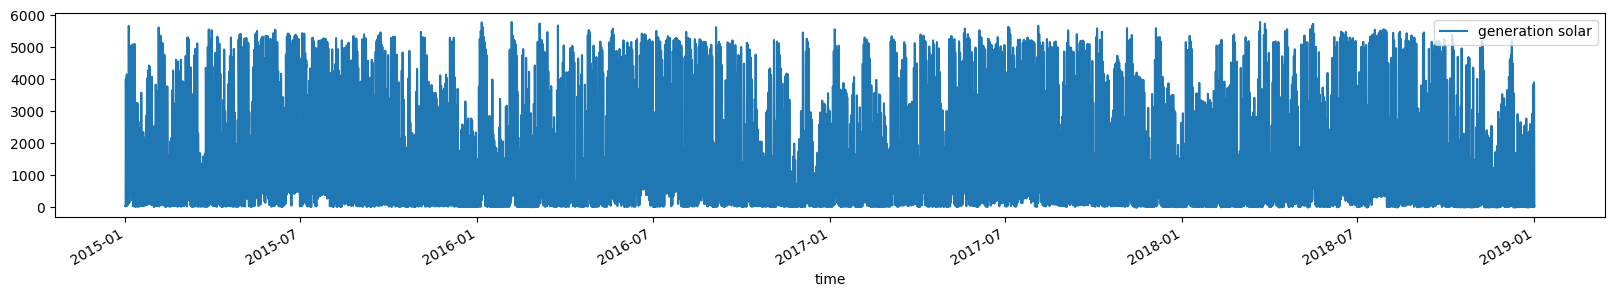

In [8]:
for target_column in target_columns:
    input_df.plot(x=timestamp_column, y=target_column, figsize=(20, 3))

## Preprocessing the Data

### Split the data into training and testing sets

We split the data into training, validation, and test sets. The training set is used to train the model, while the test set is used to evaluate its performance.

In [9]:
split_config = {"train": 0.6, "test": 0.2}

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": [],
    "target_columns": target_columns,
    "control_columns": [
        "temp",
        "temp_min",
        "temp_max",
        "pressure",
        "wind_speed",
        "wind_deg",
        "humidity",
        "rain_1h",
        "rain_3h",
        "clouds_all",
    ],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=prediction_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_df, valid_df, test_df = prepare_data_splits(input_df, context_length=context_length, split_config=split_config)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp,
    input_df,
    split_config,
    fewshot_fraction=fewshot_fraction,
    fewshot_location="first",
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 931, val = 6919, test = 6917


## Fine-tuning the Model

### Load the model for finetuning
The TTM model is hosted on [HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1), and is loaded into a `TinyTimeMixerForPrediction` model. We have 12 input channels in this example (two targets plus 10 exogenous). Note that we also enable channel mixing in the decoder as well as forecast channel mixing. This allows the decoder to be tuned to capture interactions between the channels. Forecast channel mixing allows incorporating the effect of exogenous values which are known during the forecast horizon.

In [ ]:
# Instantiate the model.
set_seed(42)
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r1",  # Name of the model on HuggingFace.
    num_input_channels=tsp.num_input_channels,
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    fcm_use_mixer=True,
    fcm_context_length=10,
    enable_forecast_channel_mixing=True,
    decoder_mode="mix_channel",
)

### Freeze the TTM Backbone

During fine tuning we freeze the backbone and focus on tuning only the parameters in the decoder. This reduces the overall number of parameters being tuned while also maintaining the pre-trained backbone.

In [11]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 1083630
Number of params after freezing the backbone 568046


### Set up a Trainer for Finetune Few-shot 5%

Configure a Trainer for use in fine-tuning and evaluating the model. 

In [12]:
# Important parameters
learning_rate: float = 0.0001
num_epochs: int = 200
patience: int = 2
batch_size: int = 256

print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    use_cpu=finetune_forecast_model.device.type != "cuda",
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=patience,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.00001,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

Using learning rate = 0.0001


### Train the Model

Here we train the model on the fraction of data that was selected above (5% of the training data). This tunes only the weights in the decoder and output layers, as the other weights have been frozen.


In [13]:
# Fine tune
finetune_forecast_trainer.train()

Epoch,Training Loss,Validation Loss
1,0.570900,0.476796
2,0.553700,0.473587
3,0.549500,0.470246
4,0.542500,0.466691
5,0.546000,0.462846
6,0.540400,0.458651
7,0.541800,0.454060
8,0.533600,0.449028
9,0.525500,0.443532
10,0.522100,0.437559


[TrackingCallback] Mean Epoch Time = 61.344073426966766 seconds, Total Train Time = 6352.49845790863


TrainOutput(global_step=196, training_loss=0.43017837101099443, metrics={'train_runtime': 6352.498, 'train_samples_per_second': 29.311, 'train_steps_per_second': 0.126, 'total_flos': 1822339287982080.0, 'train_loss': 0.43017837101099443, 'epoch': 49.0})

### Evaluate the Model

Evaluate the fine-tuned model on the test dataset.

In [14]:
# generate forecasts using the finetuned model
pipeline = TimeSeriesForecastingPipeline(
    finetune_forecast_model,
    device="cpu",  # Specify your local GPU or CPU.
    feature_extractor=tsp,
)

# Make a forecast on the target column given the input data.
finetune_forecast = pipeline(test_df)
finetune_forecast.head()

,time,total load actual_prediction,generation solar_prediction,total load actual,generation solar
0,2018-03-14 19:00:00+01:00,"[35479.4008706617, 34495.569734850185, 32618.6...","[359.32251656580297, 218.4873830512904, 184.08...","[36229.999787301436, 35065.000150100284, 32327...","[27.00002827514345, 17.000040225963403, 17.000..."
1,2018-03-14 20:00:00+01:00,"[35169.80247260729, 32927.62667146694, 30268.0...","[366.42316909587066, 249.6375731104763, 224.06...","[35065.000150100284, 32327.999963904855, 29527...","[17.000040225963403, 17.000040225963403, 17.00..."
2,2018-03-14 21:00:00+01:00,"[32862.422796058054, 30143.38222222922, 27737....","[380.3866675045001, 255.54710810101005, 190.71...","[32327.999963904855, 29527.999966038646, 27513...","[17.000040225963403, 17.000040225963403, 17.00..."
3,2018-03-14 22:00:00+01:00,"[29740.799914987827, 27470.30226559242, 25568....","[383.6575014779478, 224.525051759309, 150.6059...","[29527.999966038646, 27513.00002212207, 25726....","[17.000040225963403, 17.000040225963403, 22.00..."
4,2018-03-14 23:00:00+01:00,"[27337.4168905127, 25461.071040277733, 24283.3...","[370.27750277891914, 172.29314324167763, 92.80...","[27513.00002212207, 25726.000086681644, 24749....","[17.000040225963403, 22.000034250553426, 42.00..."


In [15]:
# Define some standard metrics.
def custom_metric(actual, prediction, column_header="results"):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    p = np.asarray(prediction.tolist())

    mask = ~np.any(np.isnan(a), axis=1)

    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    mae = np.mean(np.abs(a[mask, :] - p[mask, :]))
    return pd.DataFrame(
        {
            column_header: {
                "mean_squared_error": mse,
                "root_mean_squared_error": np.sqrt(mse),
                "mean_absolute_error": mae,
            }
        }
    )


custom_metric(
    finetune_forecast["total load actual"],
    finetune_forecast["total load actual_prediction"],
    "fine-tune forecast (total load)",
)

,fine-tune forecast (total load)
mean_squared_error,8.235900e+06
root_mean_squared_error,2.869826e+03
mean_absolute_error,2.163161e+03


### Plot the Predictions vs. Actuals

Plot the predictions vs. actuals for some random samples of time intervals in test dataset.

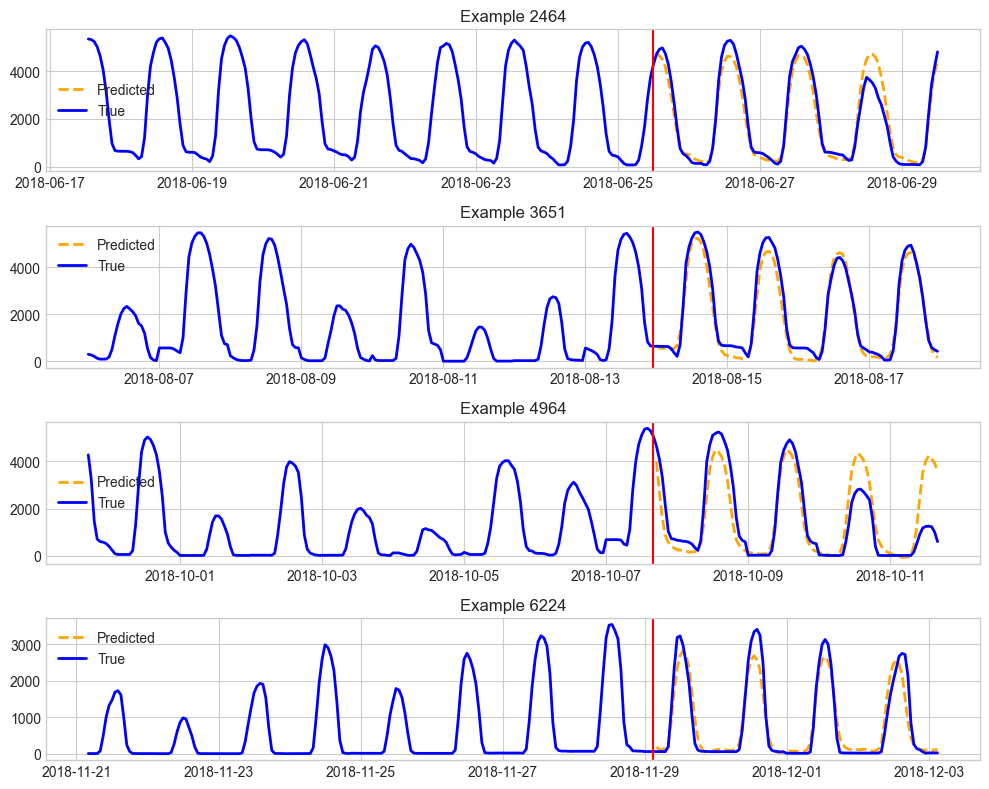

In [16]:
# plot
plot_predictions(
    input_df=test_df,
    predictions_df=finetune_forecast,
    timestamp_column=timestamp_column,
    freq=tsp.freq,
    plot_dir=None,
    plot_prefix="Test",
    channel="generation solar",  # "total load actual",
    plot_context=2 * prediction_length,
    indices=[2464, 3651, 4964, 6224],
    num_plots=4,
)

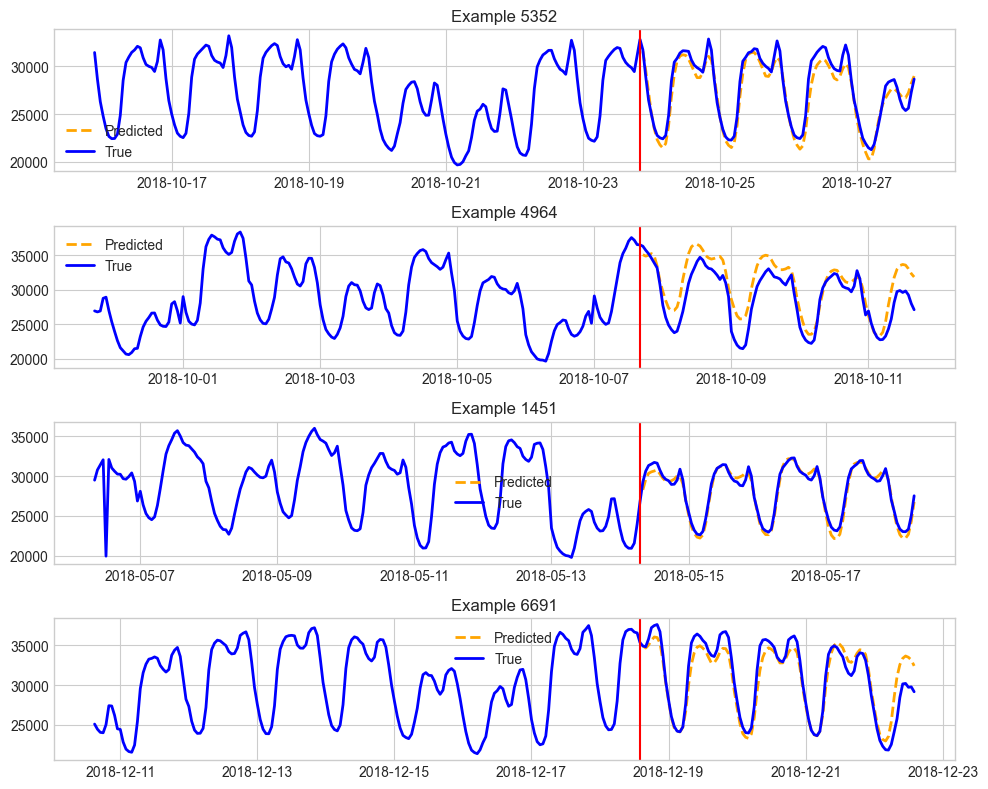

In [17]:
plot_predictions(
    input_df=test_df,
    predictions_df=finetune_forecast,
    timestamp_column=timestamp_column,
    freq=tsp.freq,
    plot_dir=None,
    plot_prefix="Test",
    channel="total load actual",
    plot_context=2 * prediction_length,
    indices=[5352, 4964, 1451, 6691],
    num_plots=4,
)

## Making the Forecast

### Create a forecasting pipeline with the fine-tuned model

We extract the appropriate historical data (context) and future values of control variables, and then set up the forecasting pipeline with the model and time series preprocessor.

We choose a context window near the end of the test dataset, while still leaving enough known data from which we extract the controls. This is meant to simulate the case where you have historical information for the inputs and also provide future values of the controls.

In [18]:
historical_df = input_df.iloc[-context_length-prediction_length:-prediction_length].copy()
controls_df = input_df.iloc[-prediction_length:][column_specifiers["control_columns"]].copy()

# Create a pipeline.
pipeline = TimeSeriesForecastingPipeline(
    finetune_forecast_trainer.model,
    feature_extractor=tsp,
    device="cpu",  # Specify your local GPU or CPU.
)

# Make a forecast on the target column given the input data.
future_forecast = pipeline(historical_df, future_time_series=controls_df)
future_forecast.tail()

,time,total load actual_prediction,generation solar_prediction,total load actual,generation solar
0,2018-12-27 23:00:00+01:00,"[25870.234039473922, 23790.824368866393, 22488...","[234.1088781683536, 105.54808137550026, 52.708...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


### Plot predictions along with the historical data.

The predicted series picks up where the historical data ends, and we can see that it predicts a continuation of the cyclical pattern.

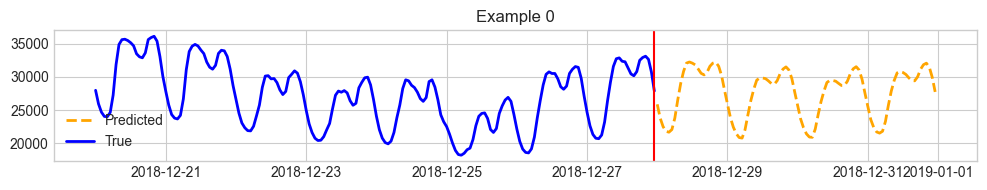

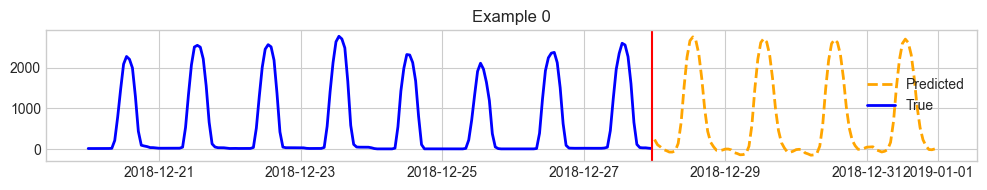

In [19]:
# Pre-cast the timestamp to avoid future dtype inference changes
historical_df[timestamp_column] = pd.to_datetime(historical_df[timestamp_column])

# Plot the historical data and predicted series.
plot_predictions(
    input_df=historical_df,
    predictions_df=future_forecast,
    freq=tsp.freq,
    timestamp_column=timestamp_column,
    channel=target_columns[0],
)
plot_predictions(
    input_df=historical_df,
    predictions_df=future_forecast,
    freq=tsp.freq,
    timestamp_column=timestamp_column,
    channel=target_columns[1],
)

## Links
* Library: [Granite TSFM on Github](https://github.com/ibm-granite/granite-tsfm)
* Model: [TinyTimeMixer on HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1)
* Dataset: [Hourly Energy Demand Generation and Weather on Kaggle](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather)